<a href="https://colab.research.google.com/github/lk480/IIB_Project/blob/main/SA_UNET_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [24]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


In [2]:
!pip install keras_cv

In [10]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, \
    Conv2D, Add, Activation, Lambda,Conv1D
import keras
import keras.backend as K

def spatial_attention(input_feature):
    kernel_size = 7

    if K.image_data_format() == "channels_first":
        channel = input_feature.shape[1]
        cbam_feature = Permute((2, 3, 1))(input_feature)
    else:
        channel = input_feature.shape[-1]
        cbam_feature = input_feature

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters=1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          kernel_initializer='he_normal',
                          use_bias=False)(concat)
    assert cbam_feature.shape[-1] == 1

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [56]:
#SA-UNET Model

from keras.optimizers import *
from keras.models import Model

from keras.layers import Input,Conv2DTranspose, MaxPooling2D,BatchNormalization,concatenate,Activation
from keras_cv.layers import DropBlock2D

def Backbone(input_size=(None, None, 3), block_size=7,rate=0.1,start_neurons=16,lr=1e-3):

    inputs = Input(input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = DropBlock2D(block_size=block_size, rate=rate)(conv1)
    conv1= BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(conv1)
    conv1 = DropBlock2D(block_size=block_size, rate=rate)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)



    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = DropBlock2D(block_size=block_size, rate=rate)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(conv2)
    conv2 = DropBlock2D(block_size=block_size, rate=rate)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)


    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = DropBlock2D(block_size=block_size, rate=rate)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(conv3)
    conv3 = DropBlock2D(block_size=block_size, rate=rate)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    convm = DropBlock2D(block_size=block_size, rate=rate)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)
    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(convm)
    convm = DropBlock2D(block_size=block_size, rate=rate)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, rate=rate)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, rate=rate)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, rate=rate)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, rate=rate)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])


    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, rate=rate)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, rate=rate)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)

    model = Model(input=inputs, output=output_layer)

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

    return model

def SA_UNet(input_size=(None, None, 3), block_size=7,rate=0.1,start_neurons=16,lr=1e-3):

    inputs = Input(input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = DropBlock2D(block_size=block_size, rate=rate)(conv1)
    conv1= BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(conv1)
    conv1 = DropBlock2D(block_size=block_size, rate=rate)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)



    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = DropBlock2D(block_size=block_size, rate=rate)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(conv2)
    conv2 = DropBlock2D(block_size=block_size, rate=rate)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)


    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = DropBlock2D(block_size=block_size, rate=rate)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(conv3)
    conv3 = DropBlock2D(block_size=block_size, rate=rate)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    convm = DropBlock2D(block_size=block_size, rate=rate)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)
    convm = spatial_attention(convm)
    convm = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(convm)
    convm = DropBlock2D(block_size=block_size, rate=rate)(convm)
    convm = BatchNormalization()(convm)
    convm = Activation('relu')(convm)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])

    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, rate=rate)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = DropBlock2D(block_size=block_size, rate=rate)(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Activation('relu')(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])

    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, rate=rate)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = DropBlock2D(block_size=block_size, rate=rate)(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Activation('relu')(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])


    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, rate=rate)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = DropBlock2D(block_size=block_size, rate=rate)(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Activation('relu')(uconv1)
    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)

    model = Model(inputs=inputs, outputs=output_layer)

    model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [57]:
model = SA_UNet()
model.load_weights('/content/drive/MyDrive/SA-UNet_HVI/Model/CHASE/SA_UNet.h5')

In [58]:
test_image_dir = '/content/drive/MyDrive/CHASE 2/test/image'
test_mask_dir = '/content/drive/MyDrive/CHASE 2/test/label'
test_image_filenames = os.listdir(test_image_dir)
test_mask_filenames = os.listdir(test_mask_dir)

def sorted_paths(image_filenames, mask_filenames, image_dir, mask_dir):
  image_paths = []
  mask_paths = []
  for image_name in image_filenames:
      for mask_name in mask_filenames:
          if image_name[:-4] == mask_name[:-10]:
              image_paths.append(os.path.join(image_dir, image_name))
              mask_paths.append(os.path.join(mask_dir, mask_name))
  assert len(image_paths) == len(mask_paths)
  return image_paths, mask_paths


def load_data(image_path, mask_path, size=(512,512)):
  #Load Image
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 3)
  image = tf.image.resize(image, size)
  image = tf.cast(image, tf.float32) / 255.0

  #Load Mask
  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, 1)
  mask = tf.image.resize(mask, size)
  mask = tf.cast(mask, tf.float32) / 255.0
  return image, mask


test_image_paths, test_mask_paths = sorted_paths(test_image_filenames, test_mask_filenames, test_image_dir, test_mask_dir)
test_image_paths_tensor = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_mask_paths_tensor = tf.data.Dataset.from_tensor_slices(test_mask_paths)
test_dataset = tf.data.Dataset.zip(test_image_paths_tensor, test_mask_paths_tensor)
test_dataset = test_dataset.map(load_data)
print(len(test_dataset))

8


In [59]:
#Batch test data
batch_size = 32
test_data_batched = test_dataset.batch(batch_size)
predictions = model.predict(test_data_batched)

1/1 [==============================] - 0s 379ms/step


In [60]:
from sklearn.metrics import f1_score
f1_score_list = []
#Calculate F1 Score
for i in range(0,8):
  test_image_element, test_mask_element = load_data(test_image_paths[i], test_mask_paths[i])

  #Convert to NumPy Arrays
  image = test_image_element.numpy()
  ground_truth_mask = test_mask_element.numpy()

  prediction = predictions[i]
  #print(f"File Path: {test_image_paths[i]}")

  #Convert to Binary
  threshold = 0.5
  predicted_binary = (prediction > threshold).astype(np.uint8)
  ground_truth_binary = (ground_truth_mask > threshold).astype(np.uint8)
  #ground_truth_binary = np.squeeze(ground_truth_binary)

  #print(np.shape(predicted_binary), np.shape(ground_truth_binary))
  assert np.shape(predicted_binary) == np.shape(ground_truth_binary)

  #Calculate Metrics
  f1 = f1_score(ground_truth_binary.flatten(), predicted_binary.flatten())
  f1_score_list.append(f1)

print(f"F1 Score: {np.mean(f1_score_list)}")


F1 Score: 0.7514938029282785


In [61]:
#PGM to PNG Conversion
from PIL import Image
def convert_pgm_to_png(image_path):
  try:
      with Image.open(image_path) as img:
          if img.mode != 'RGB':
              img = img.convert('RGB')
          return img
          print(f"File converted successfully. Saved at {output_path}")
  except Exception as e:
      print(f"An error occurred: {e}")

png_image = convert_pgm_to_png('/content/drive/MyDrive/PartIIB_HVI_Project/python_registration/ECC_out/willeye_euclidean/MII_start_0_end_95.pgm')
png_array = np.array(png_image)
print(np.shape(png_array))

(1024, 1360, 3)


(1024, 1360, 3)


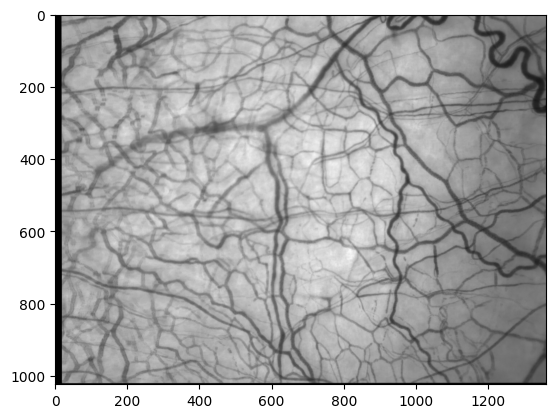

In [69]:
import cv2
def load_hvi(image_path, size=(1024,1360)):
  image = np.array(convert_pgm_to_png(image_path))
  image = np.array(image)
  #grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #image = np.expand_dims(grayscale_image, -1)
  if size is not None:
    image = tf.image.resize(image, size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

hvi_image = load_hvi('/content/drive/MyDrive/PartIIB_HVI_Project/python_registration/ECC_out/willeye_euclidean/MII_start_0_end_9.pgm')
plt.imshow(hvi_image, cmap='gray')
print(np.shape(hvi_image))

1/1 [==============================] - 0s 38ms/step


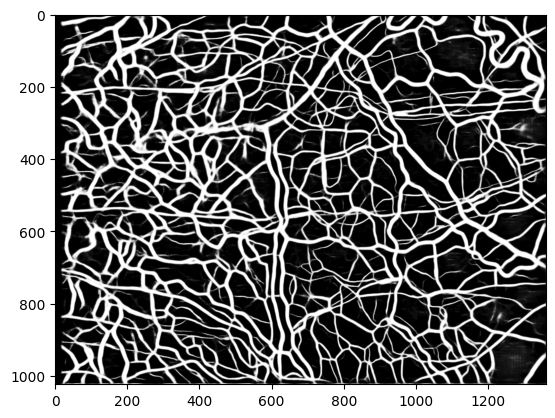

In [70]:
hvi_batched = tf.expand_dims(hvi_image, axis=0)
prediction = model.predict(hvi_batched)
predicted_mask = prediction[0]
plt.imshow(predicted_mask, cmap='gray')